# Prediction with a pre-trained model (Keras)

In [11]:
# Step 1: Import Libraries and Configure Environment
import os, sys, glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import tensorflow as tf
# -- Keras interface --
from tensorflow.keras.models import load_model
from unet3_keras import cross_entropy_balanced      # <- your custom loss

2025-08-02 21:30:48.841271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754163048.859687  106713 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754163048.865468  106713 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754163048.880432  106713 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754163048.880456  106713 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754163048.880458  106713 computation_placer.cc:177] computation placer alr

In [12]:
# GPU growth (unchanged)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"{len(gpus)} GPU(s) found")
else:
    print("No GPU detected – running on CPU")


1 GPU(s) found


In [13]:
try:
    # When running as a .py script
    ROOT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # When running in a Jupyter notebook
    ROOT_DIR = os.getcwd()

In [14]:
# Step 2: Define Paths and Parameters
# --- Data Paths ---
BASE_DIR = ROOT_DIR

ORIG_DATA_DIR = os.path.join(BASE_DIR, "data")
VAL_DIR       = os.path.join(ORIG_DATA_DIR, "validation_npy")
MODEL_DIR     = os.path.join(BASE_DIR, "model")          # holds gxl.dat & outputs

# --- Model Paths ---------------------------------------------------
MODEL_DIR  = os.path.join(BASE_DIR, "model")
MODEL_NAME = "unet_keras_model_200pairs_25epochs_2025-08-02_17-03-28.keras"
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_NAME)
F3D_DIR = os.path.join(ROOT_DIR, "..", "data", "data_from_Wu", "prediction", "f3d")
F3D_DIR = os.path.abspath(F3D_DIR)           # normalise ".." → absolute

# optional safety-check
assert os.path.exists(os.path.join(F3D_DIR, "gxl.dat")), \
       f"gxl.dat not found in {F3D_DIR}"
# --- Model Input Parameters ---------------------------------------
PATCH_N1 = PATCH_N2 = PATCH_N3 = 128
OVERLAP  = 12                                # ditto


In [15]:
# Step 3: Load the trained Keras model
print("Loading model:", MODEL_PATH)
model = load_model(MODEL_PATH,
                   custom_objects={"cross_entropy_balanced": cross_entropy_balanced})
model.summary()


Loading model: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_2019_keras_updated/model/unet_keras_model_200pairs_25epochs_2025-08-02_17-03-28.keras


I0000 00:00:1754163051.845061  106713 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21746 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:41:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │    442,496 │ conv3d_6[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d       │ (None, 32, 32,    │          0 │ conv3d_7[0][0]    │
│ (UpSampling3D)      │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling3d[0]… │
│ (Concatenate)       │ 32, 192)          │            │ conv3d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 32, 32,    │    331,840 │ concatenate[0][0] │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 32, 32,    │    110,656 │ conv3d_8[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling3d_1     │ (None, 64, 64,    │          0 │ conv3d_9[0][0]  

 Total params: 4,378,757 (16.70 MB)

 Trainable params: 1,459,585 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,919,172 (11.14 MB)

In [16]:
def plot_prediction_slices(gx_slice, fx_slice, fp_slice, title_suffix=""):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Slice {title_suffix}", fontsize=16)
    ax1.set_title("Input Seismic");    ax1.imshow(gx_slice.T, cmap='gray', vmin=-2, vmax=2)
    ax2.set_title("Ground-Truth");     ax2.imshow(fx_slice.T, cmap='gray', vmin=0, vmax=1)
    ax3.set_title("Prediction");       ax3.imshow(fp_slice.T, cmap='gray', vmin=0, vmax=1)
    for ax in (ax1, ax2, ax3): ax.axis('off')
    plt.tight_layout(); plt.show()


I0000 00:00:1754163053.270259  106867 service.cc:152] XLA service 0x7c2a2804f6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754163053.270308  106867 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-08-02 21:30:53.296798: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1754163053.364116  106867 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-08-02 21:30:53.846514: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-08-02 21:30:53.990812: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please i

Displaying slice 64


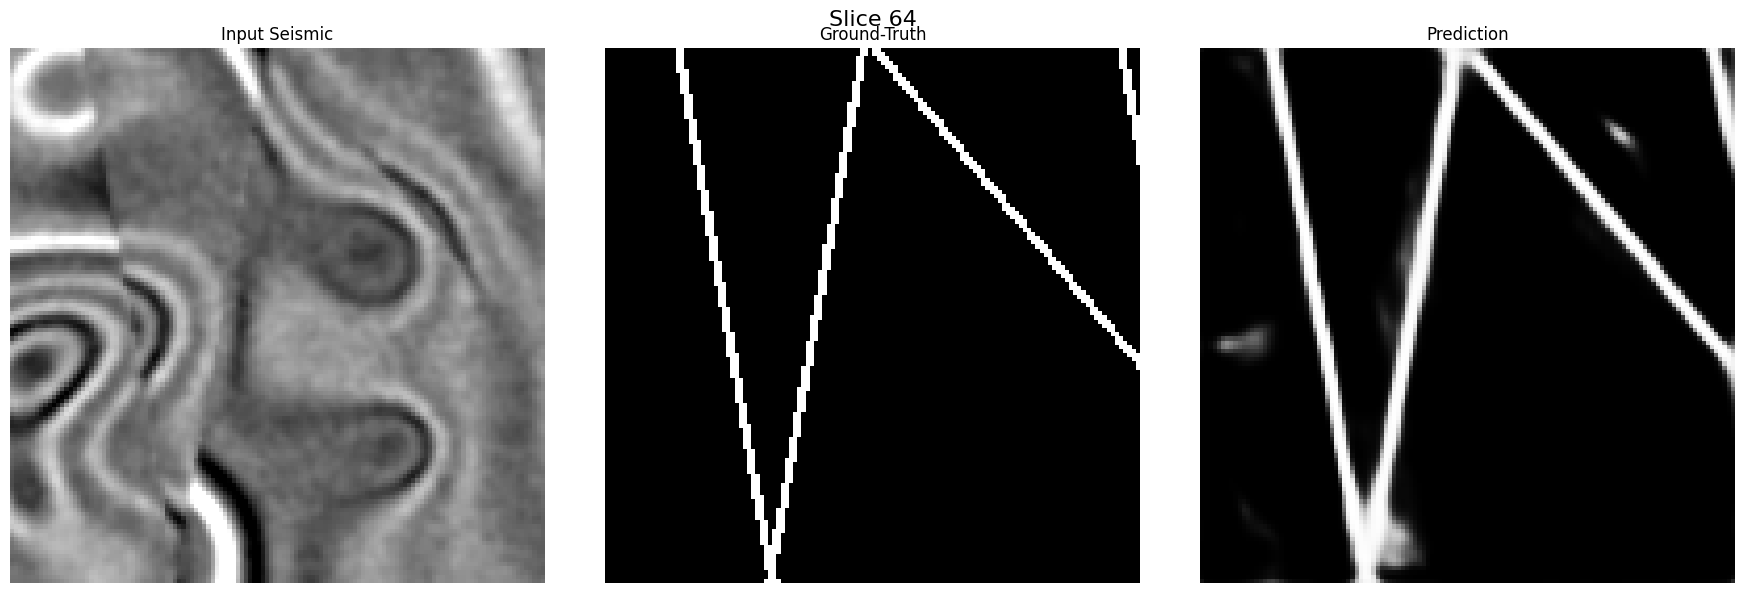

In [17]:
# Step 4: Simple Prediction on a Validation Sample
SAMPLE_ID = "10"
gx = np.load(os.path.join(VAL_DIR, "seis", f"{SAMPLE_ID}.npy"))
fx = np.load(os.path.join(VAL_DIR, "fault", f"{SAMPLE_ID}.npy"))

gx_norm  = (gx - gx.mean()) / (gx.std() + 1e-8)
gx_tr    = np.transpose(gx_norm)
fx_tr    = np.transpose(fx)

inp      = gx_tr.reshape(1, PATCH_N1, PATCH_N2, PATCH_N3, 1)
fp_tr    = model.predict(inp, verbose=0)[0, ..., 0]

SLICE = 64
print(f"Displaying slice {SLICE}")
plot_prediction_slices(gx_tr[SLICE], fx_tr[SLICE], fp_tr[SLICE], SLICE)


Seismic data shape for plotting: (512, 384, 128)
Prediction data shape for plotting: (512, 384, 128)


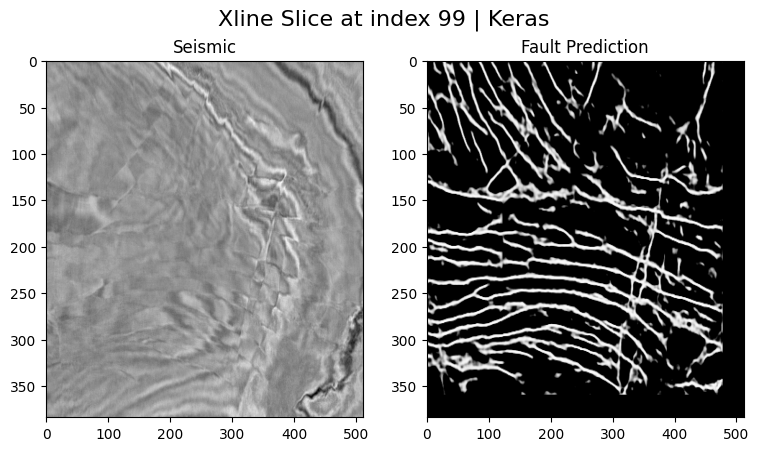

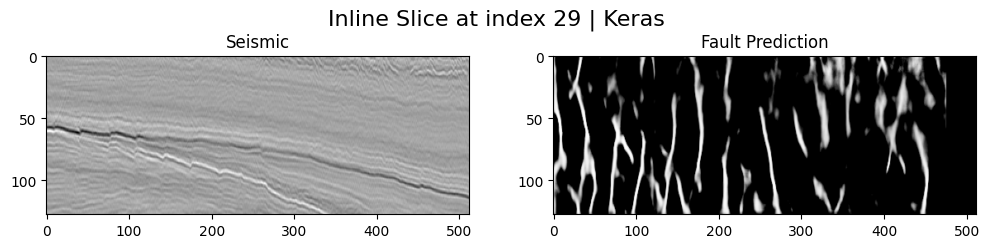

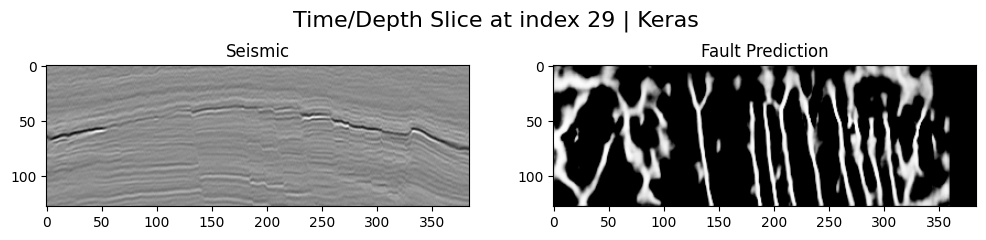

In [18]:
# --- 1. Reload Data in Original Orientation ---
# This ensures our slicing logic matches the author's exactly.
# Original dimensions are (depth, inline, xline)
m3, m2, m1 = 512, 384, 128 

# Load the original seismic volume
seismic_path = os.path.join(F3D_DIR, 'gxl.dat')
gx_orig_view = np.fromfile(seismic_path, dtype=np.single).reshape(m3, m2, m1)

# Load the fault prediction we just saved with Keras
prediction_path = os.path.join(F3D_DIR, "fp_keras.dat")
# The saved fp_final was (xline, inline, depth), so we transpose it back
# to match the original seismic orientation for consistent slicing.
fp_transposed = np.fromfile(prediction_path, dtype=np.single).reshape(m1, m2, m3)
fp_orig_view = np.transpose(fp_transposed)

print(f"Seismic data shape for plotting: {gx_orig_view.shape}")
print(f"Prediction data shape for plotting: {fp_orig_view.shape}")


# --- 2. Define Slice Indices (from original notebook) ---
k1_depth, k2_inline, k3_xline = 29, 29, 99


# --- 3. Plot Each Slice Type in a Separate Figure ---

# --- Xline Slice ---
gx_slice = gx_orig_view[:, :, k3_xline]
fp_slice = fp_orig_view[:, :, k3_xline]
fig = plt.figure(figsize=(9, 9))
# --- FIX: Added y=0.92 to move the title down ---
plt.suptitle(f'Xline Slice at index {k3_xline} | Keras', fontsize=16, y=0.75)
# Seismic
p1 = plt.subplot(1, 2, 1)
p1.set_title("Seismic")
p1.imshow(np.transpose(gx_slice), aspect=1.5, cmap=plt.cm.gray)
# Prediction
p2 = plt.subplot(1, 2, 2)
p2.set_title("Fault Prediction")
p2.imshow(np.transpose(fp_slice), aspect=1.5, interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.show()


# --- Inline Slice ---
gx_slice = gx_orig_view[:, k2_inline, :]
fp_slice = fp_orig_view[:, k2_inline, :]
fig = plt.figure(figsize=(12, 12))
# --- FIX: Added y=0.92 to move the title down ---
plt.suptitle(f'Inline Slice at index {k2_inline} | Keras', fontsize=16, y=0.6)
# Seismic
p1 = plt.subplot(1, 2, 1)
p1.set_title("Seismic")
p1.imshow(np.transpose(gx_slice), aspect=1.5, cmap=plt.cm.gray)
# Prediction
p2 = plt.subplot(1, 2, 2)
p2.set_title("Fault Prediction")
p2.imshow(np.transpose(fp_slice), aspect=1.5, interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.show()


# --- Time/Depth Slice ---
gx_slice = gx_orig_view[k1_depth, :, :]
fp_slice = fp_orig_view[k1_depth, :, :]
fig = plt.figure(figsize=(12, 12))
# --- FIX: Added y=0.92 to move the title down ---
plt.suptitle(f'Time/Depth Slice at index {k1_depth} | Keras', fontsize=16, y=0.6)
# Seismic
p1 = plt.subplot(1, 2, 1)
p1.set_title("Seismic")
p1.imshow(np.transpose(gx_slice), cmap=plt.cm.gray)
# Prediction
p2 = plt.subplot(1, 2, 2)
p2.set_title("Fault Prediction")
p2.imshow(np.transpose(fp_slice), interpolation="bilinear", vmin=0.4, vmax=1.0, cmap=plt.cm.gray)
plt.show()
